In [1]:
!pip install tifffile

  Using cached https://files.pythonhosted.org/packages/17/e8/76979051a2a15b23e2652a3cdeb7d3dfec518c54138bd0f8b5a5ef2c267a/tifffile-2020.2.16-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/9a/8e/d3fe77a4e6442b20d0b25fe19c04fde2844f2db4370bf4daec6403834052/imagecodecs-2020.2.18-cp36-cp36m-manylinux2010_x86_64.whl


In [2]:
import tensorflow as tf
tf.enable_eager_execution()

In [3]:
print(tf.version)

<module 'tensorflow._api.v1.version' from '/opt/conda/lib/python3.6/site-packages/tensorflow/_api/v1/version/__init__.py'>


In [4]:
import os
import tifffile as tiff
import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(threshold=False)

In [5]:
import random
import numpy as np

def get_rand_patch(img, mask, sz=160):
    """
    :param img: ndarray with shape (x_sz, y_sz, num_channels)
    :param mask: binary ndarray with shape (x_sz, y_sz, num_classes)
    :param sz: size of random patch
    :return: patch with shape (sz, sz, num_channels)
    """
    #print(len(img.shape), img.shape[0], img.shape[1], img.shape[0:1], mask.shape[0:1])
    assert len(img.shape) == 3 and img.shape[0] > sz and img.shape[1] > sz and img.shape[0:2] == mask.shape[0:2]
    xc = random.randint(0, img.shape[0] - sz)
    yc = random.randint(0, img.shape[1] - sz)
    patch_img = img[xc:(xc + sz), yc:(yc + sz)]
    patch_mask = mask[xc:(xc + sz), yc:(yc + sz)]

    # Apply some random transformations
    random_transformation = np.random.randint(1,8)
    if random_transformation == 1:  # reverse first dimension
        patch_img = patch_img[::-1,:,:]
        patch_mask = patch_mask[::-1,:,:]
    elif random_transformation == 2:    # reverse second dimension
        patch_img = patch_img[:,::-1,:]
        patch_mask = patch_mask[:,::-1,:]
    elif random_transformation == 3:    # transpose(interchange) first and second dimensions
        patch_img = patch_img.transpose([1,0,2])
        patch_mask = patch_mask.transpose([1,0,2])
    elif random_transformation == 4:
        patch_img = np.rot90(patch_img, 1)
        patch_mask = np.rot90(patch_mask, 1)
    elif random_transformation == 5:
        patch_img = np.rot90(patch_img, 2)
        patch_mask = np.rot90(patch_mask, 2)
    elif random_transformation == 6:
        patch_img = np.rot90(patch_img, 3)
        patch_mask = np.rot90(patch_mask, 3)
    else:
        pass

    return patch_img, patch_mask


def get_patches_val():
    trainIds = [str(i).zfill(2) for i in range(11, 12)]  # all availiable ids: from "01" to "24"
    x_dict = dict()
    y_dict = dict()
    sz = 320
    n_patches = 100000000
    #print('Reading images')
    for img_id in trainIds:
        #print(tiff.imread('./Data/{}.tif'.format(img_id)).shape)
        print(img_id + ' read')
        img_m = normalize(tiff.imread('./Data/{}.tif'.format(img_id)))
        #print(img_m.shape)
        mask_stg1 = tiff.imread('./Label/{}.tif'.format(img_id))[:,:,np.newaxis] # / 255
        mask_stg2 = mask_stg1 >= 40.
        mask = mask_stg2.astype(int)
        #mask = mask_stg1
        #print(mask.shape)
        train_xsz = int(3/4 * img_m.shape[0])  # use 75% of image as train and 25% for validation
        x_dict[img_id] = img_m[:, :, :]
        y_dict[img_id] = mask[:, :, :]
        #print(img_id + ' read')
    x = list()
    y = list()
    total_patches = 0
    while total_patches < n_patches:
        #print("debug")
        img_id = random.sample(x_dict.keys(), 1)[0]
        img = x_dict[img_id]
        mask = y_dict[img_id]
        img_patch, mask_patch = get_rand_patch(img, mask, sz)
        x.append(img_patch)
        y.append(mask_patch)
        total_patches += 1
    #print('Generated {} patches'.format(total_patches))
        yield np.array(img_patch), np.array(mask_patch)
        #yield np.array(x), np.array(y)
        
def get_patches():
    trainIds = [str(i).zfill(2) for i in range(1, 11)]  # all availiable ids: from "01" to "24"
    x_dict = dict()
    y_dict = dict()
    sz = 320
    n_patches = 1000000000
    #print('Reading images')
    for img_id in trainIds:
        print(img_id + ' read')
        #print(tiff.imread('./Data/{}.tif'.format(img_id)).shape)
        img_m = normalize(tiff.imread('./Data/{}.tif'.format(img_id)))
        #print(img_m.shape)
        mask_stg1 = tiff.imread('./Label/{}.tif'.format(img_id))[:,:,np.newaxis] # / 255
        mask_stg2 = mask_stg1 >= 40.
        mask = mask_stg2.astype(int)
        #mask = mask_stg1
        #print(mask.shape)
        train_xsz = int(3/4 * img_m.shape[0])  # use 75% of image as train and 25% for validation
        x_dict[img_id] = img_m[:, :, :]
        y_dict[img_id] = mask[:, :, :]
        #print(img_id + ' read')
    x = list()
    y = list()
    total_patches = 0
    while total_patches < n_patches:
        #print("debug")
        img_id = random.sample(x_dict.keys(), 1)[0]
        img = x_dict[img_id]
        mask = y_dict[img_id]
        img_patch, mask_patch = get_rand_patch(img, mask, sz)
        x.append(img_patch)
        y.append(mask_patch)
        total_patches += 1
    #print('Generated {} patches'.format(total_patches))
        yield np.array(img_patch), np.array(mask_patch)
        #yield np.array(x), np.array(y)

In [6]:
def acc_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    acc = K.mean(tf.cast(tf.equal(y_true,y_pred), tf.float32))
    return acc


def recall_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    true_positives = K.sum(y_true*y_pred)
    positives = K.sum(y_true)
    recall = true_positives / (positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    true_positives = K.sum(y_true*y_pred)
    predicted_positives = K.sum(y_pred)
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [7]:
# u-net model with up-convolution or up-sampling and weighted binary-crossentropy as loss func

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import keras as k


w_pos= 0.94
w_neg= 0.06

def unet_model(n_classes=1, im_sz=160, n_channels=3, n_filters_start=32, growth_factor=2, upconv=True,
               class_weights=[0.1,0.9]):
    droprate=0.2
    n_filters = n_filters_start
    inputs = Input((im_sz, im_sz, n_channels))
    #inputs = BatchNormalization()(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #pool1 = Dropout(droprate)(pool1)

    n_filters *= growth_factor
    pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(droprate)(pool2)

    n_filters *= growth_factor
    pool2 = BatchNormalization()(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(droprate)(pool3)

    n_filters *= growth_factor
    pool3 = BatchNormalization()(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_0)
    pool4_1 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    pool4_1 = Dropout(droprate)(pool4_1)

    n_filters *= growth_factor
    pool4_1 = BatchNormalization()(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_1)
    pool4_2 = MaxPooling2D(pool_size=(2, 2))(conv4_1)
    pool4_2 = Dropout(droprate)(pool4_2)

    n_filters *= growth_factor
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_2)
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv5)

    n_filters //= growth_factor
    if upconv:
        up6_1 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv5), conv4_1])
    else:
        up6_1 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4_1])
    up6_1 = BatchNormalization()(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_1)
    conv6_1 = Dropout(droprate)(conv6_1)

    n_filters //= growth_factor
    if upconv:
        up6_2 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_1), conv4_0])
    else:
        up6_2 = concatenate([UpSampling2D(size=(2, 2))(conv6_1), conv4_0])
    up6_2 = BatchNormalization()(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_2)
    conv6_2 = Dropout(droprate)(conv6_2)

    n_filters //= growth_factor
    if upconv:
        up7 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_2), conv3])
    else:
        up7 = concatenate([UpSampling2D(size=(2, 2))(conv6_2), conv3])
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(droprate)(conv7)

    n_filters //= growth_factor
    if upconv:
        up8 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    else:
        up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
    up8 = BatchNormalization()(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Dropout(droprate)(conv8)

    n_filters //= growth_factor
    if upconv:
        up9 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    else:
        up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation='sigmoid')(conv9)
    #conv10 = Conv2D(n_classes, (1, 1), activation='relu')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    def weighted_binary_crossentropy(y_true, y_pred):
        #threshold = 40.
        #labels = tf.cast(y_true > threshold, tf.float32)
        # class_loglosses = K.sum(K.binary_crossentropy(y_true, y_pred)*(y_true*w_pos+(1.0-y_true)*w_neg))
        # weight_sum = K.sum(y_true*w_pos+(1.0-y_true)*w_neg)
        # return class_loglosses/weight_sum
        return tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, pos_weight=10.0)
    #K.sum(class_loglosses * K.constant(class_weights))
    
    def margin_loss(y_true, y_pred):
        threshold = 40.0
        neg_margin = 10.0
        pos_margin = 30.0
        labels = tf.cast(y_true > threshold, tf.float32)
        neg_loss = (1.0 - labels) * tf.square(tf.maximum(0.0, y_pred- threshold + neg_margin))*w_neg
        pos_loss = labels*(tf.square(tf.maximum(0.0, threshold - y_pred + pos_margin)))*w_pos
        loss =  tf.reduce_sum(neg_loss + pos_loss)
        weight_sum = K.sum(labels*w_pos+(1.0-labels)*w_neg)
        return loss/weight_sum
    #K.sum(class_loglosses * K.constant(class_weights))

    #model.compile(optimizer=Adam(lr=0.0005), loss=weighted_binary_crossentropy, metrics=['accuracy', recall_m, precision_m])
    #model.compile(optimizer=Adam(lr=0.0005), loss=margin_loss)
    model.compile(optimizer=Adam(lr=0.001), loss="binary_crossentropy",metrics=[acc_m, recall_m, precision_m, f1_m])
    #print(K.eval(model.optimizer.lr))
    #model.summary()
    return model

Using TensorFlow backend.


In [15]:
import os.path
import numpy as np
import tifffile as tiff
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

def normalize(img):
    min = img.min()
    max = img.max()
    x = 2.0 * (img - min) / (max - min) - 1.0
    return x

N_BANDS = 4
N_CLASSES = 1  # Irrigated/Non Irrigated
CLASS_WEIGHTS = [0.1,0.9]
N_EPOCHS = 100
UPCONV = True
PATCH_SZ = 320  # should divide by 16
BATCH_SIZE = 150
TRAIN_SZ = 10000  # train size
VAL_SZ = 1000    # validation size


def get_model():
    return unet_model(N_CLASSES, PATCH_SZ, n_channels=N_BANDS, upconv=UPCONV, class_weights=CLASS_WEIGHTS)


weights_path = 'weights'
if not os.path.exists(weights_path):
    os.makedirs(weights_path)
weights_path += '/unet_weights.hdf5'

# trainIds = [str(i).zfill(2) for i in range(1, 4)]  # all availiable ids: from "01" to "24"


# if __name__ == '__main__':
#     X_DICT_TRAIN = dict()
#     Y_DICT_TRAIN = dict()
#     X_DICT_VALIDATION = dict()
#     Y_DICT_VALIDATION = dict()

#     print('Reading images')
#     for img_id in trainIds:
#         print(tiff.imread('./Data/{}.tif'.format(img_id)).shape)
#         img_m = normalize(tiff.imread('./Data/{}.tif'.format(img_id)))
#         print(img_m.shape)
#         mask_stg1 = tiff.imread('./Label/{}.tif'.format(img_id))[:,:,np.newaxis] # / 255
#         mask_stg2 = mask_stg1 >0.
#         mask = mask_stg2.astype(int)
#         print(mask.shape)
#         train_xsz = int(3/4 * img_m.shape[0])  # use 75% of image as train and 25% for validation
#         X_DICT_TRAIN[img_id] = img_m[:, :, :]
#         Y_DICT_TRAIN[img_id] = mask[:, :, :]
#         X_DICT_VALIDATION[img_id] = img_m[:, :, :]
#         Y_DICT_VALIDATION[img_id] = mask[:, :, :]
#         #X_DICT_TRAIN[img_id] = img_m[:train_xsz, :, :]
#         #Y_DICT_TRAIN[img_id] = mask[:train_xsz, :, :]
#         #X_DICT_VALIDATION[img_id] = img_m[train_xsz:, :, :]
#         #Y_DICT_VALIDATION[img_id] = mask[train_xsz:, :, :]
#         print(img_id + ' read')
#     print('Images were read')

def train_net():
    print("start train net")
    dataset = tf.data.Dataset.from_generator(get_patches, (tf.float32, tf.int16))
    dataset_val = tf.data.Dataset.from_generator(get_patches_val, (tf.float32, tf.int16))
    #iterator = dataset.make_one_shot_iterator()
    #dataset = dataset.batch(10)
    #x,y = iterator.get_next()
    #print(tf.shape(x))
    model = get_model()
    model_checkpoint = ModelCheckpoint(weights_path, verbose=1, save_weights_only=True, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, min_lr=0.0005)
    #model_checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True)
    csv_logger = CSVLogger('log_unet.csv', append=True, separator=';')
    #tensorboard = TensorBoard(log_dir='./tensorboard_unet', write_graph=True, write_images=True)
    results = model.fit_generator(dataset.batch(32),steps_per_epoch=10000,epochs=200,
                verbose=2, shuffle=True,
                callbacks=[model_checkpoint, csv_logger, 
                           #tensorboard, 
                           #early_stopping,
                           reduce_lr],
                validation_data= dataset_val.batch(32), validation_steps = 1000)    
        
    return 

train_net()
    
    


start train net
01 read
Epoch 1/200
02 read
03 read
04 read
05 read
06 read
07 read
08 read
09 read
10 read
11 read
1000/1000 [==============================] - 226s 226ms/step - loss: 4.2521 - acc_m: 0.9661 - recall_m: 0.1319 - precision_m: 0.3246 - f1_m: 0.1720

Epoch 00001: val_loss improved from inf to 4.25215, saving model to weights/unet_weights.hdf5
 - 3799s - loss: 3.8213 - acc_m: 0.9677 - recall_m: 7.5280e-04 - precision_m: 0.0768 - f1_m: 0.0013 - val_loss: 4.2521 - val_acc_m: 0.9661 - val_recall_m: 0.1319 - val_precision_m: 0.3246 - val_f1_m: 0.1720
Epoch 2/200
11 read
1000/1000 [==============================] - 231s 231ms/step - loss: 3.2199 - acc_m: 0.9701 - recall_m: 0.0406 - precision_m: 0.5088 - f1_m: 0.0698

Epoch 00002: val_loss improved from 4.25215 to 3.21992, saving model to weights/unet_weights.hdf5
 - 3779s - loss: 3.4204 - acc_m: 0.9682 - recall_m: 0.0512 - precision_m: 0.4555 - f1_m: 0.0819 - val_loss: 3.2199 - val_acc_m: 0.9701 - val_recall_m: 0.0406 - val_pre

KeyboardInterrupt: 

In [10]:
# u-net model with up-convolution or up-sampling and weighted binary-crossentropy as loss func

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import keras as k


w_pos= 0.94
w_neg= 0.06

def unet_model_1(n_classes=1, im_sz=160, n_channels=3, n_filters_start=32, growth_factor=2, upconv=True,
               class_weights=[0.1,0.9]):
    droprate=0.1
    n_filters = n_filters_start
    inputs = Input((im_sz, im_sz, n_channels))
    #inputs = BatchNormalization()(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #pool1 = Dropout(droprate)(pool1)

    n_filters *= growth_factor
    pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(droprate)(pool2)

    n_filters *= growth_factor
    pool2 = BatchNormalization()(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(droprate)(pool3)

    n_filters *= growth_factor
    pool3 = BatchNormalization()(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_0)
    pool4_1 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    pool4_1 = Dropout(droprate)(pool4_1)

    n_filters *= growth_factor
    pool4_1 = BatchNormalization()(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_1)
    pool4_2 = MaxPooling2D(pool_size=(2, 2))(conv4_1)
    pool4_2 = Dropout(droprate)(pool4_2)

    n_filters *= growth_factor
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_2)
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv5)

    n_filters //= growth_factor
    if upconv:
        up6_1 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv5), conv4_1])
    else:
        up6_1 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4_1])
    up6_1 = BatchNormalization()(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_1)
    conv6_1 = Dropout(droprate)(conv6_1)

    n_filters //= growth_factor
    if upconv:
        up6_2 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_1), conv4_0])
    else:
        up6_2 = concatenate([UpSampling2D(size=(2, 2))(conv6_1), conv4_0])
    up6_2 = BatchNormalization()(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_2)
    conv6_2 = Dropout(droprate)(conv6_2)

    n_filters //= growth_factor
    if upconv:
        up7 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_2), conv3])
    else:
        up7 = concatenate([UpSampling2D(size=(2, 2))(conv6_2), conv3])
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(droprate)(conv7)

    n_filters //= growth_factor
    if upconv:
        up8 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    else:
        up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
    up8 = BatchNormalization()(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Dropout(droprate)(conv8)

    n_filters //= growth_factor
    if upconv:
        up9 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    else:
        up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation='sigmoid')(conv9)
    #conv10 = Conv2D(n_classes, (1, 1), activation='relu')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    def weighted_binary_crossentropy(y_true, y_pred):
        #threshold = 40.
        #labels = tf.cast(y_true > threshold, tf.float32)
        # class_loglosses = K.sum(K.binary_crossentropy(y_true, y_pred)*(y_true*w_pos+(1.0-y_true)*w_neg))
        # weight_sum = K.sum(y_true*w_pos+(1.0-y_true)*w_neg)
        # return class_loglosses/weight_sum
        return tf.nn.weighted_cross_entropy_with_logits(tf.cast(y_true, tf.float32), y_pred, pos_weight=8.0)
    #K.sum(class_loglosses * K.constant(class_weights))
    
    def margin_loss(y_true, y_pred):
        threshold = 40.0
        neg_margin = 10.0
        pos_margin = 30.0
        labels = tf.cast(y_true > threshold, tf.float32)
        neg_loss = (1.0 - labels) * tf.square(tf.maximum(0.0, y_pred- threshold + neg_margin))*w_neg
        pos_loss = labels*(tf.square(tf.maximum(0.0, threshold - y_pred + pos_margin)))*w_pos
        loss =  tf.reduce_sum(neg_loss + pos_loss)
        weight_sum = K.sum(labels*w_pos+(1.0-labels)*w_neg)
        return loss/weight_sum
    #K.sum(class_loglosses * K.constant(class_weights))

    #model.compile(optimizer=Adam(lr=0.0005), loss=weighted_binary_crossentropy, metrics=['accuracy', recall_m, precision_m])
    #model.compile(optimizer=Adam(lr=0.0005), loss=margin_loss)
    #model.compile(optimizer=Adam(lr=0.001), loss="binary_crossentropy",metrics=[acc_m, recall_m, precision_m])
    model.compile(optimizer=Adam(lr=0.00005), loss=weighted_binary_crossentropy,metrics=[acc_m, recall_m, precision_m,f1_m])
    #print(K.eval(model.optimizer.lr))
    #model.summary()
    return model

In [11]:
import os.path
import numpy as np
import tifffile as tiff
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

def normalize(img):
    min = img.min()
    max = img.max()
    x = 2.0 * (img - min) / (max - min) - 1.0
    return x

N_BANDS = 4
N_CLASSES = 1  # Irrigated/Non Irrigated
CLASS_WEIGHTS = [0.1,0.9]
N_EPOCHS = 100
UPCONV = True
PATCH_SZ = 320  # should divide by 16
BATCH_SIZE = 150
TRAIN_SZ = 10000  # train size
VAL_SZ = 1000    # validation size


def get_model():
    return unet_model_1(N_CLASSES, PATCH_SZ, n_channels=N_BANDS, upconv=UPCONV, class_weights=CLASS_WEIGHTS)


weights_path = 'weights'
if not os.path.exists(weights_path):
    os.makedirs(weights_path)
weights_path += '/unet_weights_weighted.hdf5'

# trainIds = [str(i).zfill(2) for i in range(1, 4)]  # all availiable ids: from "01" to "24"


# if __name__ == '__main__':
#     X_DICT_TRAIN = dict()
#     Y_DICT_TRAIN = dict()
#     X_DICT_VALIDATION = dict()
#     Y_DICT_VALIDATION = dict()

#     print('Reading images')
#     for img_id in trainIds:
#         print(tiff.imread('./Data/{}.tif'.format(img_id)).shape)
#         img_m = normalize(tiff.imread('./Data/{}.tif'.format(img_id)))
#         print(img_m.shape)
#         mask_stg1 = tiff.imread('./Label/{}.tif'.format(img_id))[:,:,np.newaxis] # / 255
#         mask_stg2 = mask_stg1 >0.
#         mask = mask_stg2.astype(int)
#         print(mask.shape)
#         train_xsz = int(3/4 * img_m.shape[0])  # use 75% of image as train and 25% for validation
#         X_DICT_TRAIN[img_id] = img_m[:, :, :]
#         Y_DICT_TRAIN[img_id] = mask[:, :, :]
#         X_DICT_VALIDATION[img_id] = img_m[:, :, :]
#         Y_DICT_VALIDATION[img_id] = mask[:, :, :]
#         #X_DICT_TRAIN[img_id] = img_m[:train_xsz, :, :]
#         #Y_DICT_TRAIN[img_id] = mask[:train_xsz, :, :]
#         #X_DICT_VALIDATION[img_id] = img_m[train_xsz:, :, :]
#         #Y_DICT_VALIDATION[img_id] = mask[train_xsz:, :, :]
#         print(img_id + ' read')
#     print('Images were read')

def train_net_1():
    print("start train net")
    dataset = tf.data.Dataset.from_generator(get_patches, (tf.float32, tf.int16))
    dataset_val = tf.data.Dataset.from_generator(get_patches_val, (tf.float32, tf.int16))
    #iterator = dataset.make_one_shot_iterator()
    #dataset = dataset.batch(10)
    #x,y = iterator.get_next()
    #print(tf.shape(x))
    model_1 = get_model()
    model_checkpoint = ModelCheckpoint(weights_path, verbose=1, save_weights_only=True, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, min_lr=0.00005)
    #model_checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True)
    csv_logger = CSVLogger('log_unet.csv', append=True, separator=';')
    #tensorboard = TensorBoard(log_dir='./tensorboard_unet', write_graph=True, write_images=True)
    results = model_1.fit_generator(dataset.batch(32),steps_per_epoch=10000,epochs=200,
                verbose=2, shuffle=True,
                callbacks=[model_checkpoint, csv_logger, 
                           #tensorboard, 
                           #early_stopping,
                           reduce_lr],
                validation_data= dataset_val.batch(32), validation_steps = 1000)    
        
    return 

train_net_1()
    
    


start train net
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
01 read
Epoch 1/200
02 read
03 read
04 read
05 read
06 read
07 read
08 read
09 read
10 read
Instructions for updating:
Use tf.cast instead.


KeyboardInterrupt: 

In [10]:
!pip install rasterio

  Using cached https://files.pythonhosted.org/packages/c7/81/13321f88f582a00705c5f348724728e8999136e19d6e7c56f7e6ac9bb7f9/rasterio-1.1.3-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/e4/be/30a58b4b0733850280d01f8bd132591b4668ed5c7046761098d665ac2174/cligj-0.5.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ac/a6/1a39a1ede71210e3ddaf623982b06ecfc5c5c03741ae659073159184cd3e/affine-2.3.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e9/da/824b92d9942f4e472702488857914bdd50f73021efea15b4cad9aca8ecef/click_plugins-1.1.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/dd/c0/4d8f43a9b16e289f36478422031b8a63b54b6ac3b1ba605d602f10dd54d6/click-7.1.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/cc/0e/d27d6e806d6c0d1a2cfdc5d1f088e42339a0a54a09c3343f7f81ec8947ea/snuggs-1.4.7-py3-none-any.whl


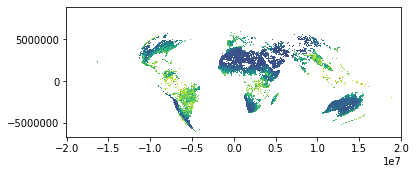

In [12]:
import rasterio as rio
from rasterio.plot import show

## Plotting Single-Band Image
with rio.open(r'./Data/test.tif') as src_plot:
    show(src_plot)

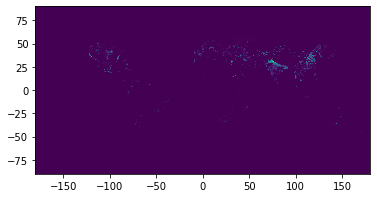

In [13]:
import rasterio as rio
from rasterio.plot import show

## Plotting Single-Band Image
with rio.open(r'./Label/06.tif') as src_plot:
    show(src_plot)

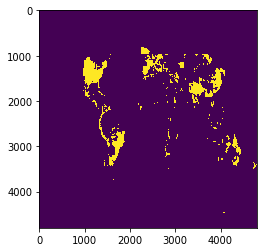

In [35]:
with rio.open(r'result_2019.tif') as src_plot:
    show(src_plot)

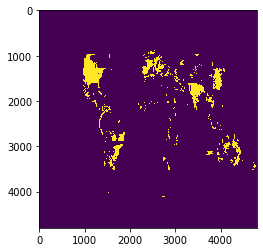

In [32]:
with rio.open(r'result_2019.tif') as src_plot:
    show(src_plot)

In [33]:
weights_path = 'weights'
if not os.path.exists(weights_path):
    os.makedirs(weights_path)
weights_path += '/unet_weights.hdf5_0407'

In [34]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

def normalize(img):
    min = img.min()
    max = img.max()
    x = 2.0 * (img - min) / (max - min) - 1.0
    return x



N_BANDS = 4
N_CLASSES = 1  # Irrigated/Non Irrigated
CLASS_WEIGHTS = [0.1,0.9]
N_EPOCHS = 100
UPCONV = True
PATCH_SZ = 320  # should divide by 16

def get_model():
    return unet_model(N_CLASSES, PATCH_SZ, n_channels=N_BANDS, upconv=UPCONV, class_weights=CLASS_WEIGHTS)

def predict(x, model, patch_sz=160, n_classes=1):
    img_height = x.shape[0]
    img_width = x.shape[1]
    n_channels = x.shape[2]
    #print(img_height, img_width)
    # make extended img so that it contains integer number of patches
    npatches_vertical = math.ceil(img_height / patch_sz)
    npatches_horizontal = math.ceil(img_width / patch_sz)
    #print(npatches_vertical,npatches_horizontal)
    extended_height = patch_sz * npatches_vertical
    extended_width = patch_sz * npatches_horizontal
    ext_x = np.zeros(shape=(extended_height, extended_width, n_channels), dtype=np.float32)
     # fill extended image with mirrors:
    ext_x[:img_height, :img_width, :] = x
    for i in range(img_height, extended_height):
        ext_x[i, :, :] = ext_x[2 * img_height - i - 1, :, :]
        print ("test")
    for j in range(img_width, extended_width):
        ext_x[:, j, :] = ext_x[:, 2 * img_width - j - 1, :]

    # now we assemble all patches in one array
    patches_list = []
    for i in range(0, npatches_vertical):
        for j in range(0, npatches_horizontal):
            x0, x1 = i * patch_sz, (i + 1) * patch_sz
            y0, y1 = j * patch_sz, (j + 1) * patch_sz
            #print(x0,x1,y0,y1)
            patches_list.append(ext_x[x0:x1, y0:y1, :])
    # model.predict() needs numpy array rather than a list
    patches_array = np.asarray(patches_list)
    # predictions:
    patches_predict = model.predict(patches_array, batch_size=1)
    prediction = np.zeros(shape=(extended_height, extended_width, n_classes), dtype=np.float32)
    #print(prediction.shape, patches_predict.shape)
    #print(patches_predict.shape)
    for k in range(patches_predict.shape[0]):
        i = k // npatches_horizontal
        j = k % npatches_vertical
        x0, x1 = i * patch_sz, (i + 1) * patch_sz
        y0, y1 = j * patch_sz, (j + 1) * patch_sz
        #print(x0,x1,y0,y1,i,j,k)
        prediction[x0:x1, y0:y1, :] = patches_predict[k, :, :, :]
    return prediction[:img_height, :img_width, :]


def picture_from_mask(mask, threshold=0):
    colors = {
        0: [150, 150, 150],  # Land
        1: [223, 194, 125],
        #,  # rainfed
       2: [27, 120, 55]    # Irrigated
    }
    z_order = {
        1: 0,
        2: 1
        #,
        #3: 0
    }
    pict = 255*np.ones(shape=(3, mask.shape[1], mask.shape[2]), dtype=np.uint8)
    for ch in range(3):
            pict[ch,:,:][mask[0,:,:] > threshold] = colors[1][ch]
    #pict(1,:,:)[mask[1,:,:]> threshold] =colors[0][0] 
    #for i in range(1, 3):
    #    cl = z_order[i]
    #    for ch in range(2):
    #        pict[ch,:,:][mask[cl,:,:] > threshold] = colors[cl][ch]
    return pict


if __name__ == '__main__':
    model = get_model()
    model.load_weights(weights_path)
    test_id = 'test'
    img = normalize(tiff.imread('./Data/{}.tif'.format(test_id)))   # make channels last
    

    
    mymat = predict(img, model, patch_sz=PATCH_SZ, n_classes=N_CLASSES).transpose([2,0,1])
    result_stg = mymat >0.4
    final_tif = result_stg.astype(np.float16)
    tiff.imsave('result_2019.tif', final_tif)
    map = picture_from_mask(mymat, 0.4)
    #mask = predict(img, model, patch_sz=PATCH_SZ, n_classes=N_CLASSES).transpose([2,0,1])  # make channels first
    #map = picture_from_mask(mask, 0.5)
    #tiff.imsave('result.tif', (255*mask).astype('uint8'))
    #tiff.imsave('result.tif', mymat)
    tiff.imsave('map.tif', map)
    print("Prediction Complete")

Prediction Complete
